In [1]:
%load_ext autoreload

%autoreload 2

@Tuan

Generate the dataset in `data_processing.ipynb` and then provide the file paths here.

In [2]:
# Imports
import torch
import numpy as np

In [3]:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    mps=False

else:
    mps_device = torch.device("mps")
    mps=True

    print("MPS is available and enabled on device: {}".format(mps_device))

MPS is available and enabled on device: mps


#### Model and Data Initialization

In [4]:
from model import *
from torch.utils.data import DataLoader

windowed_data = "X_data.npy"
labels = "X_labels.npy"

# Initialize the Dataset
data = GPS_CNN_Dataset(windowed_data, labels, device=mps_device)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

# Initialize the DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=28, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

X Shape:  torch.Size([74389, 43, 51])
y Shape:  torch.Size([74389])


In [6]:
print(465 * 32)

14880


In [117]:
# initialize the model
model = GPS_CNN(num_bins=51)
if mps:
    model = model.to(mps_device)

### Training Loop

In [118]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [124]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 700 == 5:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {loss:.3f}')

    #print("got to eval")
    model.eval()
    correct = 0
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    print(f'[{epoch + 1}] loss: {running_loss:.3f}, accuracy: {correct / len(test_dataset):.3f}') 
    model.train()

[1,     6] loss: 0.129
[1,   706] loss: 0.070
[1,  1406] loss: 0.064
[1,  2106] loss: 0.194
[1] loss: 35.382, accuracy: 0.971
[2,     6] loss: 0.069
[2,   706] loss: 0.054
[2,  1406] loss: 0.040
[2,  2106] loss: 0.108
[2] loss: 46.995, accuracy: 0.961
[3,     6] loss: 0.111
[3,   706] loss: 0.246
[3,  1406] loss: 0.016
[3,  2106] loss: 0.015
[3] loss: 35.788, accuracy: 0.974
[4,     6] loss: 0.016
[4,   706] loss: 0.044
[4,  1406] loss: 0.009
[4,  2106] loss: 0.056
[4] loss: 38.556, accuracy: 0.969
[5,     6] loss: 0.079
[5,   706] loss: 0.010
[5,  1406] loss: 0.040
[5,  2106] loss: 0.043
[5] loss: 33.705, accuracy: 0.973
[6,     6] loss: 0.073
[6,   706] loss: 0.008
[6,  1406] loss: 0.232
[6,  2106] loss: 0.021
[6] loss: 41.328, accuracy: 0.969
[7,     6] loss: 0.020
[7,   706] loss: 0.006
[7,  1406] loss: 0.127
[7,  2106] loss: 0.016
[7] loss: 38.071, accuracy: 0.971
[8,     6] loss: 0.034
[8,   706] loss: 0.021
[8,  1406] loss: 0.006
[8,  2106] loss: 0.071
[8] loss: 35.112, accuracy

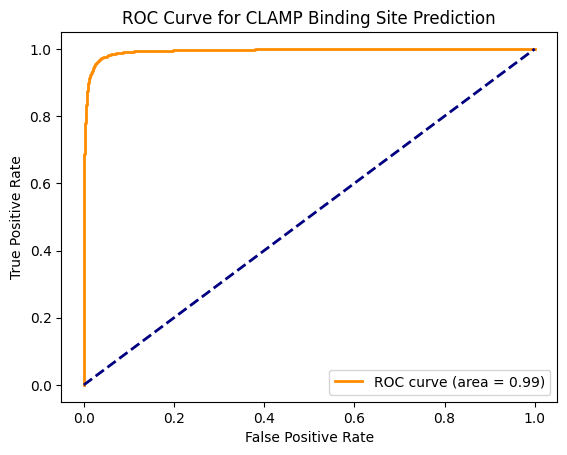

In [132]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_score = []
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_score.extend(outputs.data.cpu().numpy())

y_true = np.array(y_true)
y_score = np.array(y_score)

fpr, tpr, _ = roc_curve((y_true == 1), (y_score[:,1]))
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for CLAMP Binding Site Prediction')
plt.show()


Text(0.5, 1.0, 'Confusion Matrix for CLAMP Binding Site Prediction')

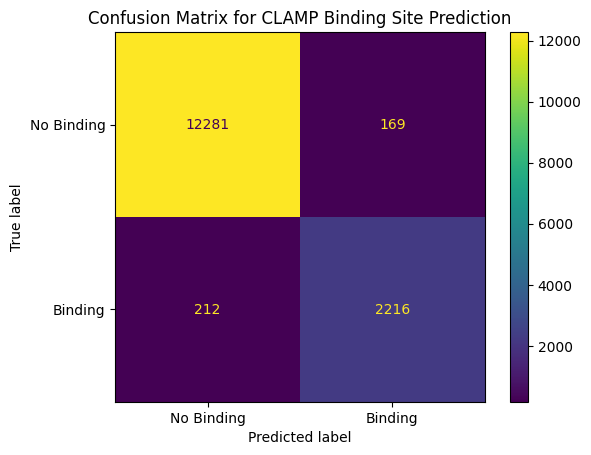

In [136]:
## Make the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(y_score, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Binding', 'Binding'], )
disp.plot()
disp.ax_.set_title('Confusion Matrix for CLAMP Binding Site Prediction')
